In [16]:

import pandas as pd

# Load the CSV file into a DataFrame to be used in the clustering process
df = pd.read_csv('Data/Partitioned_Abstracts.csv', sep=',', header=0, encoding='utf-8')

#verify that the DataFrame is loaded correctly
df.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1228 entries, 0 to 1227
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Title                 1228 non-null   object
 1   Year                  1228 non-null   int64 
 2   Authors               1228 non-null   object
 3   Label                 1228 non-null   object
 4   Partitioned Abstract  1228 non-null   object
 5   Target                1228 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 57.7+ KB


In [17]:
from sentence_transformers import SentenceTransformer

#Create the combined text by concatenating the "Title" and "Partitioned Abstract" columns
combined_texts = df["Title"].astype(str) + "\n\n" + df["Partitioned Abstract"].astype(str)
# Convert the "Target" column to integer type for classification purposes
targets = df["Target"].astype(int)

# Load the SentenceTransformer model for generating embeddings
model = SentenceTransformer("jinaai/jina-embeddings-v3", trust_remote_code=True)

# Define the task type for the model
task = "clustering"

# Encode the combined texts using the SentenceTransformer model
embeddings = model.encode(
    combined_texts.tolist(),
    show_progress_bar=True,
    device="cuda",
    convert_to_tensor=True,
)
embeddings.shape


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Batches:   0%|          | 0/39 [00:00<?, ?it/s]

torch.Size([1228, 1024])

In [18]:
import umap.umap_ as umap
import hdbscan
import sklearn.cluster as cluster
import numpy as np
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
    
# Perform UMAP dimensionality reduction on the embeddings
umap_embedding = umap.UMAP(random_state=42).fit_transform(embeddings.cpu().to(torch.float32).numpy())


/home/etienne/DTI5125_Assignment2/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/etienne/DTI5125_Assignment2/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


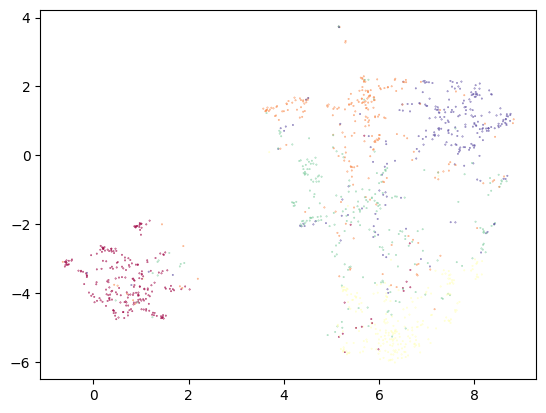

In [19]:
# Visualize the UMAP embedding with actual targets
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=targets, s=0.1, cmap='Spectral')

/home/etienne/DTI5125_Assignment2/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/etienne/DTI5125_Assignment2/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


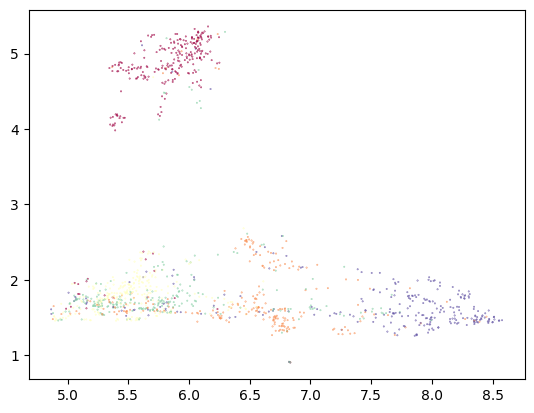

In [25]:
clusterable_embedding = umap.UMAP(
    n_neighbors=20,
    min_dist=0.1,
    n_components=16,
    random_state=42,
).fit_transform(embeddings.cpu().to(torch.float32).numpy())

plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=targets, s=0.1, cmap='Spectral')

/home/etienne/DTI5125_Assignment2/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/etienne/DTI5125_Assignment2/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


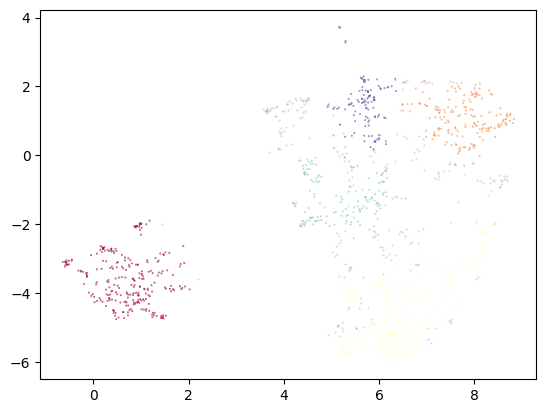

In [ ]:
#
labels = hdbscan.HDBSCAN(
    min_samples=15,
    min_cluster_size=80,
    metric='euclidean',
    prediction_data=True,
    cluster_selection_method='leaf'
).fit_predict(clusterable_embedding)

clustered = (labels >= 0)
plt.scatter(umap_embedding[~clustered, 0],
            umap_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(umap_embedding[clustered, 0],
            umap_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');

In [58]:
import hdbscan
import pyvista as pv
import numpy as np
import umap.umap_ as umap

# Step 1: Reduce embeddings to 3D
umap_3d = umap.UMAP(n_components=3, random_state=42).fit_transform(clusterable_embedding)

# Step 2: HDBSCAN clustering
labels = hdbscan.HDBSCAN(
    min_samples=15,
    min_cluster_size=80,
    metric='euclidean',
    prediction_data=True,
    cluster_selection_method='leaf'
).fit_predict(clusterable_embedding)

# Step 3: Prepare points
clustered = labels >= 0
points = umap_3d

# Step 4: PyVista 3D scatter plot
plotter = pv.Plotter()
plotter.set_background("grey")

# Plot noise
plotter.add_points(points[~clustered], color="white", point_size=7, opacity=0.5)

# Plot clusters
plotter.add_points(
    points[clustered],
    scalars=labels[clustered].astype(np.float32),
    cmap="Spectral",
    point_size=7,
    show_scalar_bar=False
)

# Step 5: Save to interactive HTML (no backend argument)
plotter.export_html("umap_hdbscan_plot.html")

print("Plot saved to 'umap_hdbscan_plot.html'")


/home/etienne/DTI5125_Assignment2/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Plot saved to 'umap_hdbscan_plot.html'


In [60]:
import plotly.express as px
import pandas as pd

df_plot = pd.DataFrame(points, columns=["x", "y", "z"])
df_plot["Cluster"] = labels
df_plot["Title"] = df["Title"]

fig = px.scatter_3d(
    df_plot,
    x="x", y="y", z="z",
    color="Cluster",
    hover_name="Title",
    title="HDBSCAN Clusters in 3D",
    opacity=0.8
)

fig.update_layout(scene=dict(
    xaxis_title="X",
    yaxis_title="Y",
    zaxis_title="Z",
    bgcolor="lightgrey"
))


fig.write_html("umap_hdbscan_plotly.html")

In [ ]:
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.optimize import linear_sum_assignment

# Filter to remove noise
mask = labels != -1

# Ground truth
true_labels = df["Target"].values  # shape: (1228,)

cluster_labels = labels[mask]
gt_labels = true_labels[mask]

assert len(cluster_labels) == len(gt_labels)

# Hungarian matching to align clusters with ground truth
def align_clusters(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    aligned = np.array([mapping.get(p, -1) for p in y_pred])
    return aligned

aligned_preds = align_clusters(gt_labels, cluster_labels)

# Compute Cohen's Kappa
kappa = cohen_kappa_score(gt_labels, aligned_preds)
print(f"Cohen’s Kappa (HDBSCAN vs. Target): {kappa:.4f}")

Cohen’s Kappa (HDBSCAN vs. Target): 0.7901
